In [1207]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import datetime

In [1208]:
print(pd.__version__)
print(sns.__version__)
print(np.__version__)
print(matplotlib.__version__)

1.4.1
0.11.2
1.21.2
3.5.1


In [1209]:
df = pd.read_csv(
    '/Users/maria/Documents/spiced/spiced_projects/spiced_repo/week7/data/ECA_blended_custom/TG_STAID002759.txt', 
    skiprows=19, 
    skipinitialspace=True,
)

In [1210]:
df

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0
...,...,...,...,...
53352,111448,20220127,44,0
53353,111448,20220128,49,0
53354,111448,20220129,58,0
53355,111448,20220130,58,0


In [1211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53357 entries, 0 to 53356
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   SOUID   53357 non-null  int64
 1   DATE    53357 non-null  int64
 2   TG      53357 non-null  int64
 3   Q_TG    53357 non-null  int64
dtypes: int64(4)
memory usage: 1.6 MB


In [1212]:
df.describe()

,SOUID,DATE,TG,Q_TG
count,53357.000000,5.335700e+04,53357.000000,53357.000000
mean,119357.653541,1.948610e+07,57.050415,0.032910
std,8023.826001,4.217116e+05,614.099351,0.543108
min,111448.000000,1.876010e+07,-9999.000000,0.000000
25%,111448.000000,1.912071e+07,33.000000,0.000000
50%,111448.000000,1.949012e+07,94.000000,0.000000
75%,127488.000000,1.985072e+07,157.000000,0.000000
max,128124.000000,2.022013e+07,305.000000,9.000000


In [1213]:
df.drop(['SOUID'], axis=1, inplace=True)

In [1214]:
df['DATE'] = df['DATE'].astype(str)
df.set_index(pd.to_datetime(df['DATE']), inplace= True)
df.drop(['DATE'], axis=1, inplace=True)

In [1215]:
df['T'] = df['TG']*0.1
df.drop(['TG'], axis=1, inplace=True)

In [1216]:
df

,Q_TG,T
DATE,,
1876-01-01,0,2.2
1876-01-02,0,2.5
1876-01-03,0,0.3
1876-01-04,0,-5.8
1876-01-05,0,-9.8
...,...,...
2022-01-27,0,4.4
2022-01-28,0,4.9
2022-01-29,0,5.8


# Imputation

In [1217]:
# Quality coloumn contains info for missing values
df['Q_TG'].value_counts()

0    53161
9      195
1        1
Name: Q_TG, dtype: int64

In [1218]:
missing_values = df[df['Q_TG']==9]
missing_values.index 

DatetimeIndex(['1945-04-25', '1945-04-26', '1945-04-27', '1945-04-28',
               '1945-04-29', '1945-04-30', '1945-05-01', '1945-05-02',
               '1945-05-03', '1945-05-04',
               ...
               '1945-10-27', '1945-10-28', '1945-10-29', '1945-10-30',
               '1945-10-31', '1945-11-01', '1945-11-02', '1945-11-03',
               '1945-11-04', '1945-11-05'],
              dtype='datetime64[ns]', name='DATE', length=195, freq=None)

The 195 missing values are the days between 25.04.1945 and 05.11.1945. 

To impute them, I take the mean temperatures from 2 years before and two years after:

In [1219]:
before = df.loc['1943-04-25':'1945-04-24']
after = df.loc['1945-11-06':'1947-11-05']
before = before.groupby([before.index.month, before.index.day]).mean()
after = after.groupby([after.index.month, after.index.day]).mean()

In [1220]:
for date in missing_values.index:
    df.loc[date,'T'] = round((before.loc[(date.month,date.day),'T']+ 
                              after.loc[(date.month,date.day),'T'])/2,1)

In [1221]:
# Quality coloumn is not needed any more
df.drop(['Q_TG'], axis=1, inplace=True)

In [1222]:
df.describe()

,T
count,53357.000000
mean,9.415415
std,7.876942
min,-22.600000
25%,3.400000
50%,9.400000
75%,15.800000
max,30.500000


# Train - Test Split

In [1223]:
df_train = pd.DataFrame.copy(df.loc[:'2015-12-31'])
df_test = pd.DataFrame.copy(df.loc['2016-01-01':])

# Visualization

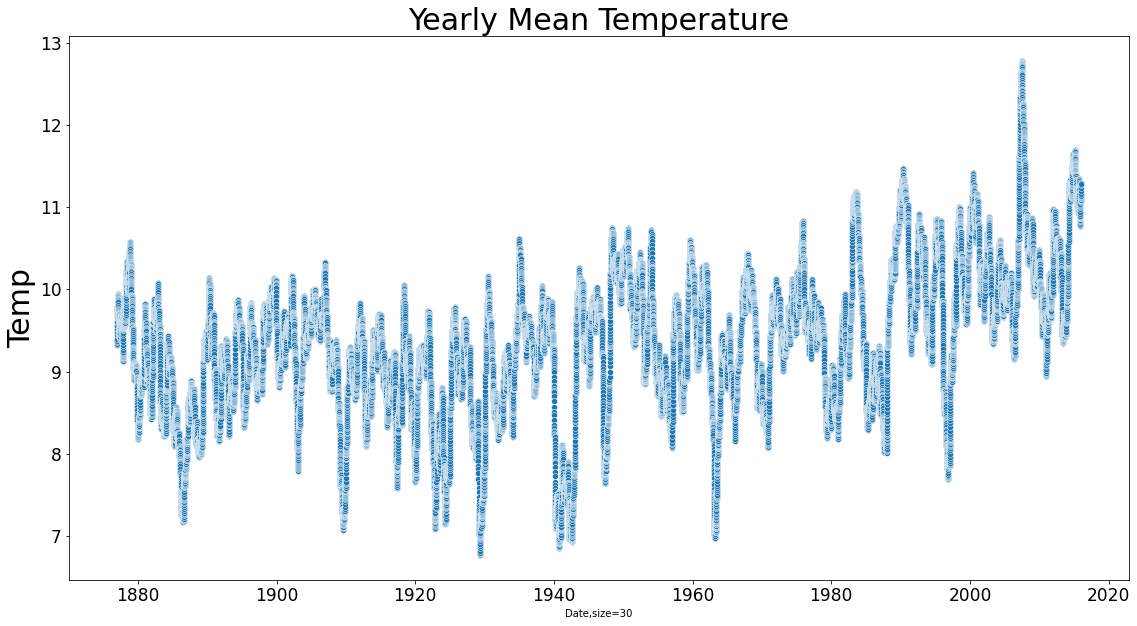

In [1224]:
plt.figure(figsize=(19,10))
sns.scatterplot(data =df_train.rolling(365).mean(), y ='T', x ='DATE')
plt.ylabel('Temp',size=30)
plt.xlabel('Date,size=30')
plt.title('Yearly Mean Temperature',size=30)
plt.xticks(size=17)
plt.yticks(size=17)
plt.show()

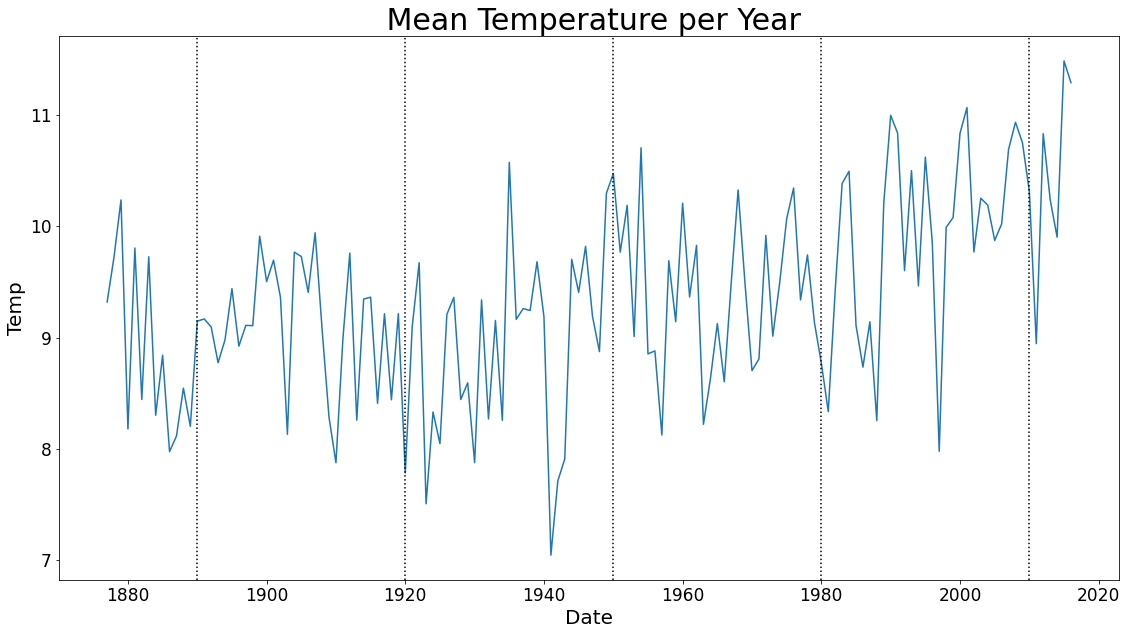

In [1225]:
plt.figure(figsize=(19,10))
sns.lineplot(data =df_train.resample('Y').mean(), y ='T', x ='DATE')
plt.ylabel('Temp',size=20)
plt.xlabel('Date',size=20)
mod = [y for y in df_train.index.year if not y%30]
for year in set(mod):
   plt.axvline(datetime.datetime(year, 1, 1), color='black', ls=':')
plt.title(' Mean Temperature per Year',size=30)
plt.xticks(size=17)
plt.yticks(size=17)
plt.show()

<AxesSubplot:xlabel='DATE', ylabel='T'>

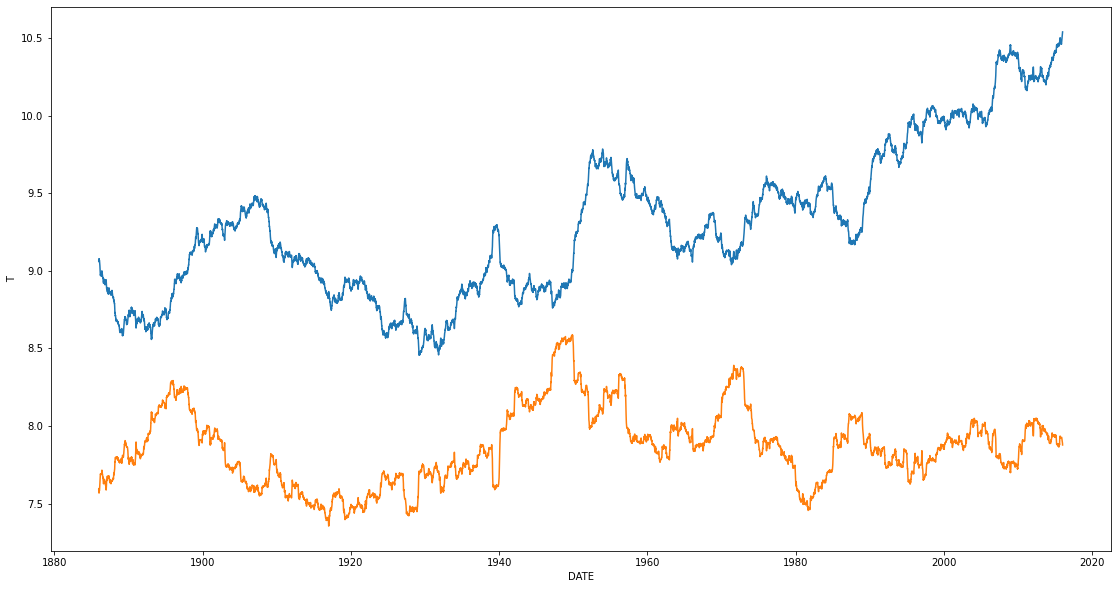

In [1226]:
plt.figure(figsize=(19,10))
sns.lineplot(data =df_train.rolling(3652).mean(), y ='T', x ='DATE')
sns.lineplot(data =df_train.rolling(3652).std(), y ='T', x ='DATE')

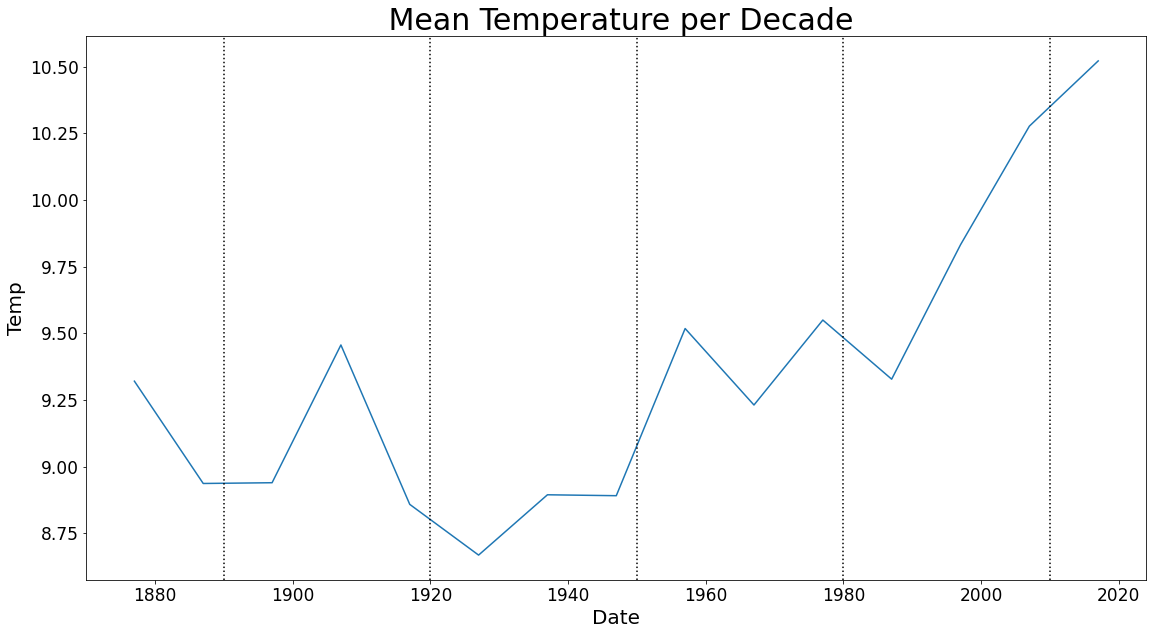

In [1227]:
plt.figure(figsize=(19,10))
sns.lineplot(data =df_train.loc[:'2020-12-31'].resample('10Y').mean(), y ='T', x ='DATE')
plt.ylabel('Temp',size=20)
plt.xlabel('Date',size=20)
mod = [y for y in df_train.index.year if not y%30]
for year in set(mod):
   plt.axvline(datetime.datetime(year, 1, 1), color='black', ls=':')
plt.title(' Mean Temperature per Decade',size=30)
plt.xticks(size=17)
plt.yticks(size=17)
plt.show()

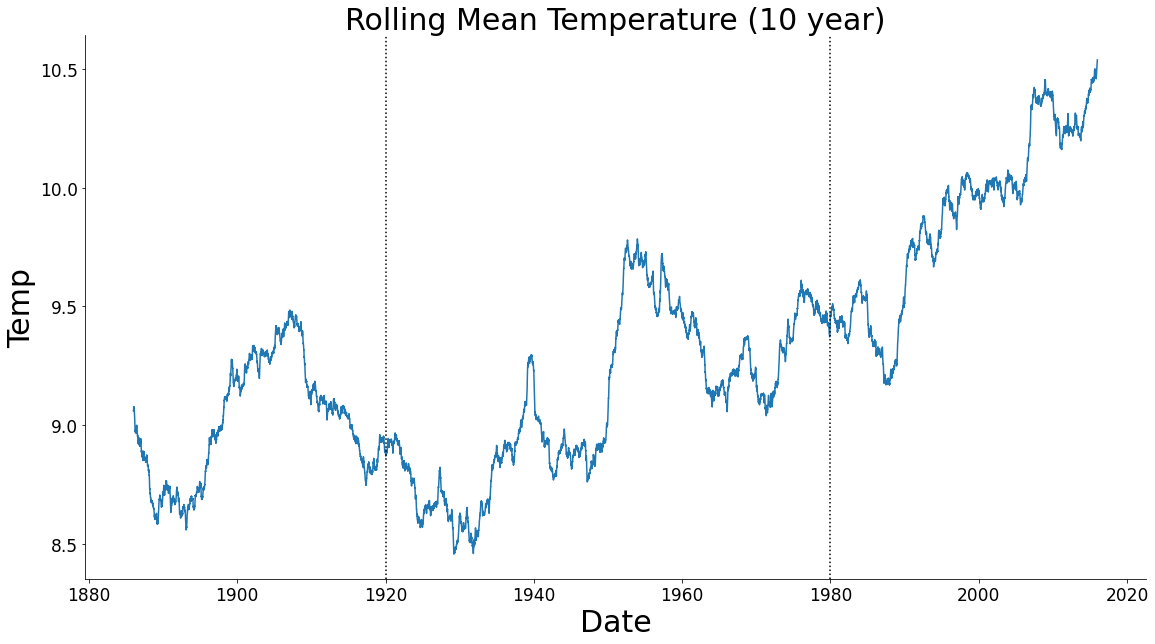

In [1228]:
plt.figure(figsize=(19,10))
sns.lineplot(data = df_train.rolling(3652).mean(), y ='T', x ='DATE', markersize=12)
mod = [y for y in df_train.index.year if not y%60]
for year in set(mod):
   plt.axvline(datetime.datetime(year, 1, 1), color='black', ls=':')
plt.ylabel('Temp',size=30)
plt.xlabel('Date',size=30)
plt.title('Rolling Mean Temperature (10 year)',size=30)
plt.xticks(size=17)
plt.yticks(size=17)
sns.despine()

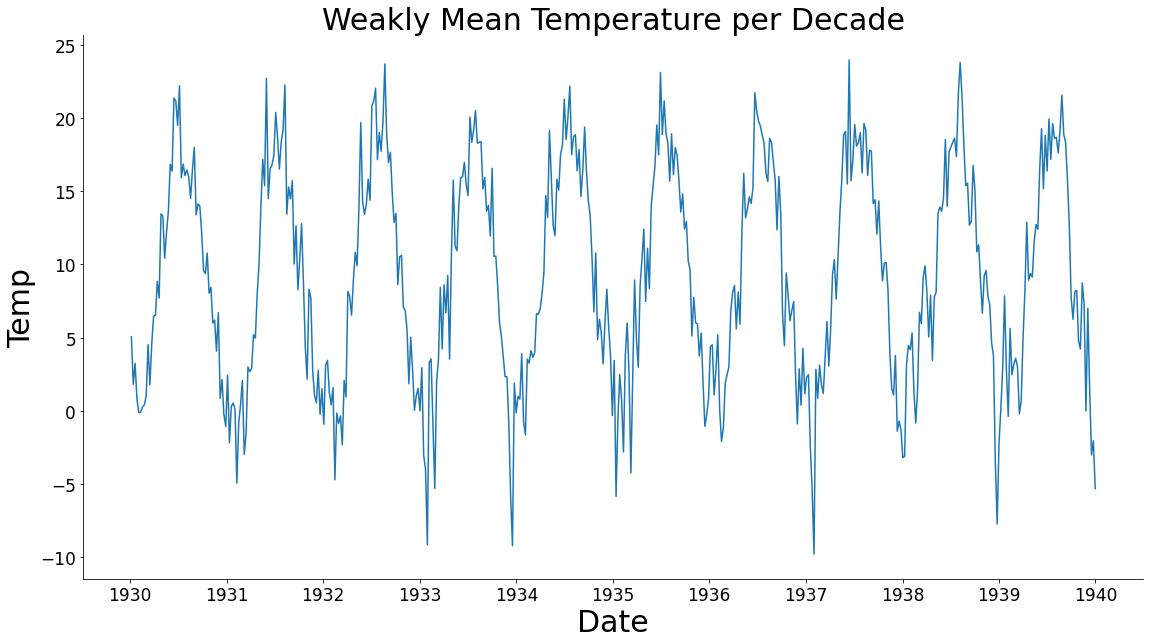

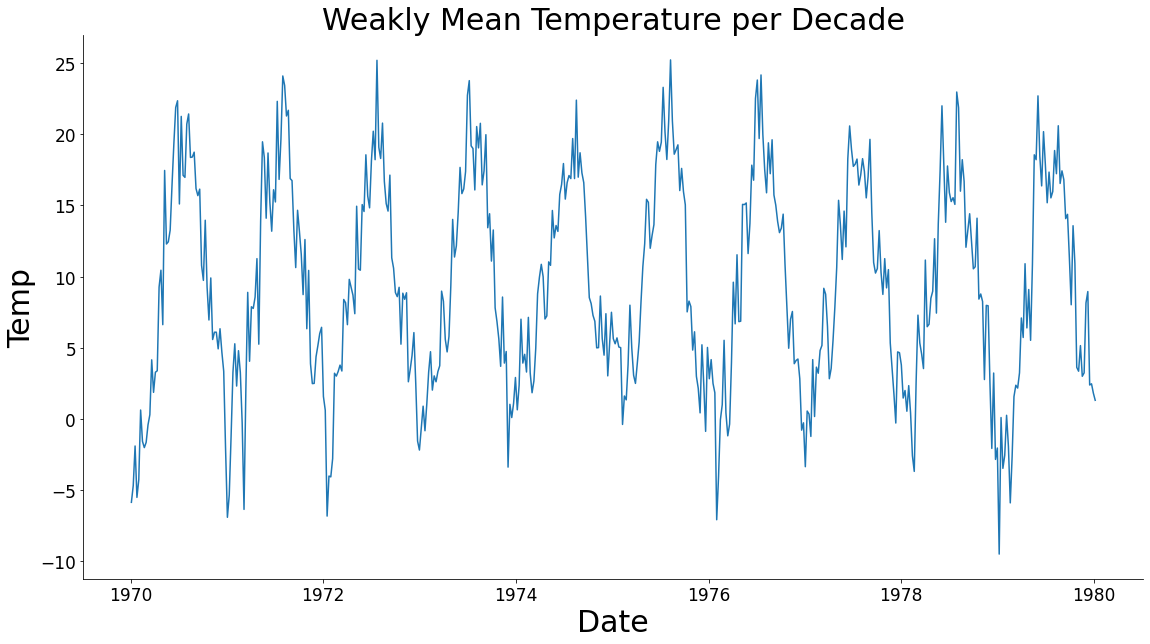

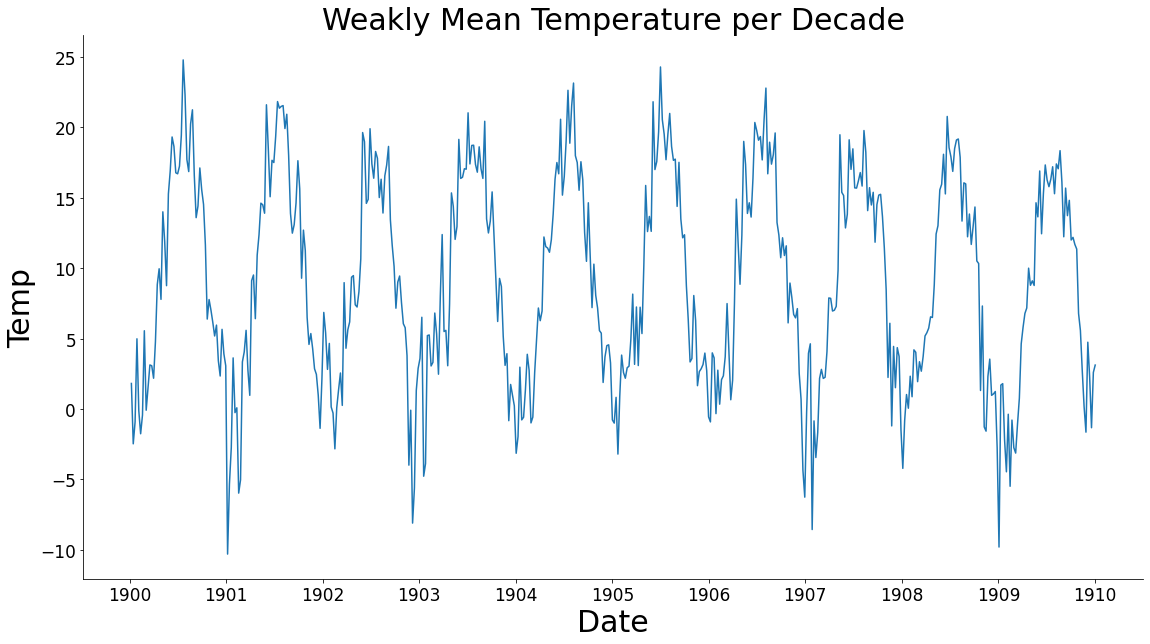

In [1229]:
mod = list(set([y for y in df_train.index.year if not y%10]))
for decade in random.sample(mod[:-2],3):
    plt.figure(figsize=(19,10))
    start = f'{decade}-01-01'
    end = f'{decade+9}-12-31'
    sns.lineplot(data = df_train['T'].loc[start:end].resample('W').mean())
    plt.title('Weakly Mean Temperature per Decade',size=30)
    plt.ylabel('Temp',size=30)
    plt.xlabel('Date',size=30)  
    plt.xticks(size=17)
    plt.yticks(size=17)
    sns.despine()

# Cycles of climate? 

### Most important: Yearly Orbit around the Sun

Solar activity: 
  * multiples of 22.75 years
  * intensity increase slowly and then decrease sharply, with a period of about 80-100 years

Ocean-atmosphere interactions: 
 1. El Niño-Southern Oscillation (ENSO): 
  * an interaction between ocean temperatures and atmospheric patterns 
  * 3 to 7 
  * years different weather conditions to different parts of the world (NASA 2009)

2. Pacific Decadal Oscillation (PDO): 
  * occurs in cycles of 25-45 years (Mantua et al. 1997), 

3. Atlantic Multi-decadal Oscillation (AMO):
  * occurring on approximately 65-85 year cycles (Deser et al. 2010). 
  * interaction with the enhanced greenhouse effect (Li et al. 2013).

### Non periodic effects

Orbit around the Sun:
  * changes in eccentricity
  * changes in the tilt of the earth's axis

Random events:
  * Volcanos
  * meteorites
  * comets

Human:
  * Greenhouse gases
  * industrial pollution particles
  * ozone depletion


source:  
 * https://www.fs.usda.gov/ccrc/education/climate-primer/natural-climate-cycles
 * http://dmod.physics.auth.gr/klima_02.htm
 

## Search for higher periodicity than the yearly 

In [1230]:
df_train

,T
DATE,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8
...,...
2015-12-27,10.7
2015-12-28,7.2
2015-12-29,4.5


In [1231]:
from scipy.interpolate import interp1d

In [1232]:
df_train['timestep'] = list(range(len(df_train)))

In [1233]:
df_train['timestep^2'] = df_train['timestep']**2
df_train

,T,timestep,timestep^2
DATE,,,
1876-01-01,2.2,0,0
1876-01-02,2.5,1,1
1876-01-03,0.3,2,4
1876-01-04,-5.8,3,9
1876-01-05,-9.8,4,16
...,...,...,...
2015-12-27,10.7,51129,2614174641
2015-12-28,7.2,51130,2614276900
2015-12-29,4.5,51131,2614379161


In [1234]:
df_train['timestep^3'] = df_train['timestep']**3
df_train

,T,timestep,timestep^2,timestep^3
DATE,,,,
1876-01-01,2.2,0,0,0
1876-01-02,2.5,1,1,1
1876-01-03,0.3,2,4,8
1876-01-04,-5.8,3,9,27
1876-01-05,-9.8,4,16,64
...,...,...,...,...
2015-12-27,10.7,51129,2614174641,133660135219689
2015-12-28,7.2,51130,2614276900,133667977897000
2015-12-29,4.5,51131,2614379161,133675820881091


In [1235]:
f = df_train.resample('Y').mean()
f

,T,timestep,timestep^2,timestep^3
DATE,,,,
1876-12-31,9.320219,182.5,4.446917e+04,1.219009e+07
1877-12-31,9.727945,548.0,3.114060e+05,1.828183e+08
1878-12-31,10.236712,913.0,8.446710e+05,7.914569e+08
1879-12-31,8.180548,1278.0,1.644386e+06,2.129902e+09
1880-12-31,9.805191,1643.5,2.712255e+06,4.494284e+09
...,...,...,...,...
2011-12-31,10.832055,49490.0,2.449271e+09,1.212155e+14
2012-12-31,10.240437,49855.5,2.485582e+09,1.239210e+14
2013-12-31,9.902740,50221.0,2.522160e+09,1.266665e+14


In [1236]:
f1 = interp1d(f['timestep'], f['T'], kind='cubic',fill_value="extrapolate")


In [1237]:
f1(df_train['timestep'])

array([11.1217942 , 11.10614477, 11.09056679, ...,  9.05951782,
        9.04155182,  9.02351818])

<AxesSubplot:xlabel='timestep', ylabel='T'>

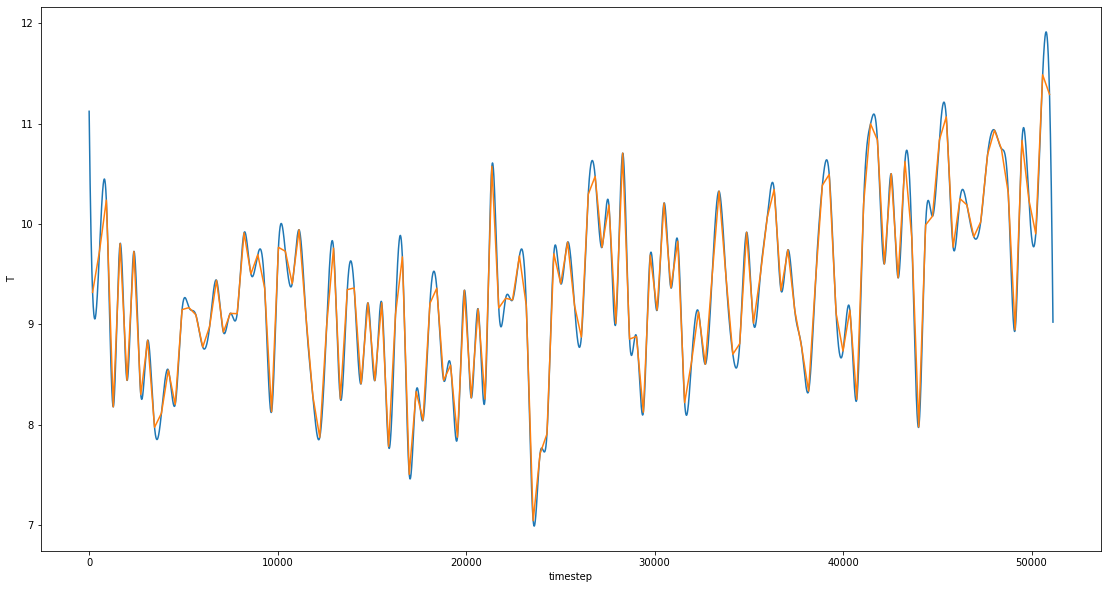

In [1238]:
plt.figure(figsize=(19,10))
sns.lineplot(y=f1(df_train['timestep']),x=df_train['timestep'])
sns.lineplot( y =f['T'], x =f['timestep'])


In [1239]:
df_train['interpolated'] = f1(df_train['timestep'])

In [1240]:
from sklearn.linear_model import LinearRegression

In [1241]:
df_train

,T,timestep,timestep^2,timestep^3,interpolated
DATE,,,,,
1876-01-01,2.2,0,0,0,11.121794
1876-01-02,2.5,1,1,1,11.106145
1876-01-03,0.3,2,4,8,11.090567
1876-01-04,-5.8,3,9,27,11.075060
1876-01-05,-9.8,4,16,64,11.059625
...,...,...,...,...,...
2015-12-27,10.7,51129,2614174641,133660135219689,9.095247
2015-12-28,7.2,51130,2614276900,133667977897000,9.077416
2015-12-29,4.5,51131,2614379161,133675820881091,9.059518


In [1242]:
m_trend = LinearRegression()
m_trend.fit(df_train[['timestep','timestep^2','timestep^3']], df_train['T'])

LinearRegression()

In [1243]:
m_trend.score(df_train[['timestep','timestep^2','timestep^3']], df_train['T'])

0.0038353690216187397

In [1244]:
df_train['trend'] = m_trend.predict(df_train[['timestep','timestep^2','timestep^3']])

In [1245]:
df_train

,T,timestep,timestep^2,timestep^3,interpolated,trend
DATE,,,,,,
1876-01-01,2.2,0,0,0,11.121794,9.053141
1876-01-02,2.5,1,1,1,11.106145,9.053130
1876-01-03,0.3,2,4,8,11.090567,9.053119
1876-01-04,-5.8,3,9,27,11.075060,9.053108
1876-01-05,-9.8,4,16,64,11.059625,9.053098
...,...,...,...,...,...,...
2015-12-27,10.7,51129,2614174641,133660135219689,9.095247,10.720026
2015-12-28,7.2,51130,2614276900,133667977897000,9.077416,10.720143
2015-12-29,4.5,51131,2614379161,133675820881091,9.059518,10.720261


<AxesSubplot:xlabel='DATE', ylabel='interpolated'>

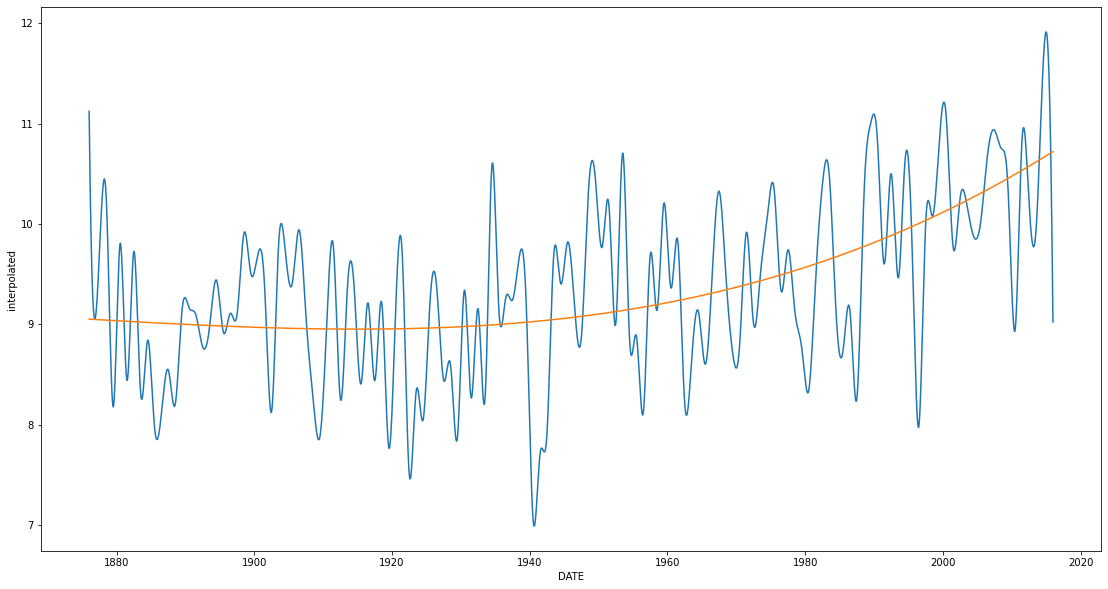

In [1246]:
plt.figure(figsize=(19,10))
sns.lineplot(data=df_train, y ='interpolated', x ='DATE')
sns.lineplot(data=df_train, y ='trend', x ='DATE')

In [1247]:
signal = df_train['interpolated'] - df_train['trend']
signal

DATE
1876-01-01    2.068654
1876-01-02    2.053015
1876-01-03    2.037448
1876-01-04    2.021952
1876-01-05    2.006527
                ...   
2015-12-27   -1.624779
2015-12-28   -1.642727
2015-12-29   -1.660743
2015-12-30   -1.678826
2015-12-31   -1.696977
Length: 51134, dtype: float64

In [1248]:
signal.describe()

count    51134.000000
mean        -0.000251
std          0.689540
min         -2.035876
25%         -0.481349
50%          0.053558
75%          0.512198
max          2.068654
dtype: float64

In [1249]:
# Number of sampling points
n = len(signal)
n

51134

<AxesSubplot:xlabel='timestep'>

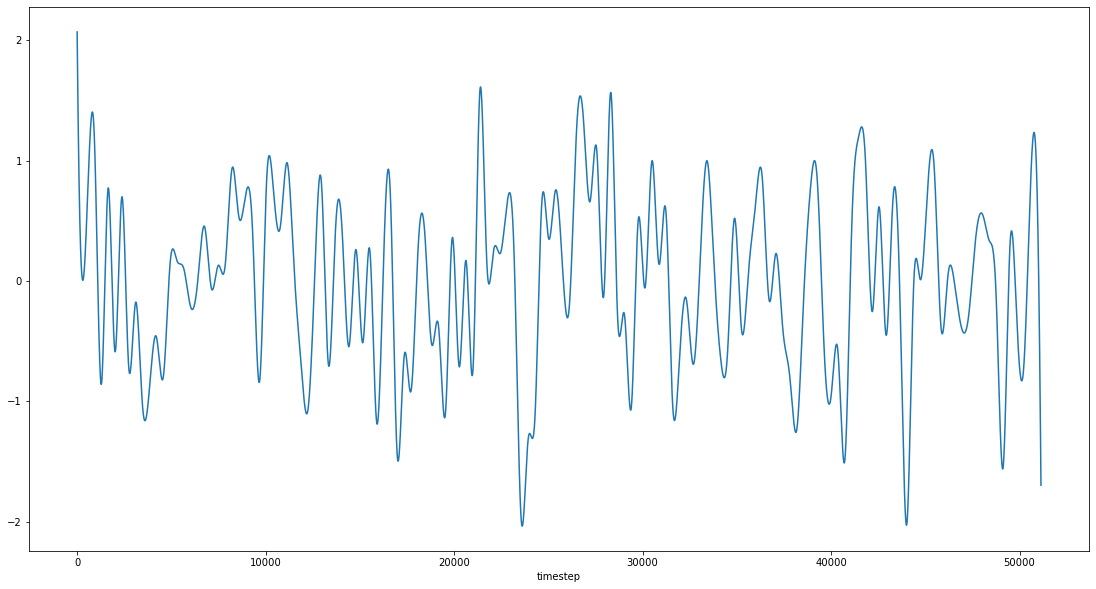

In [1250]:
plt.figure(figsize=(19,10))
sns.lineplot(y=signal,x=df_train['timestep'])

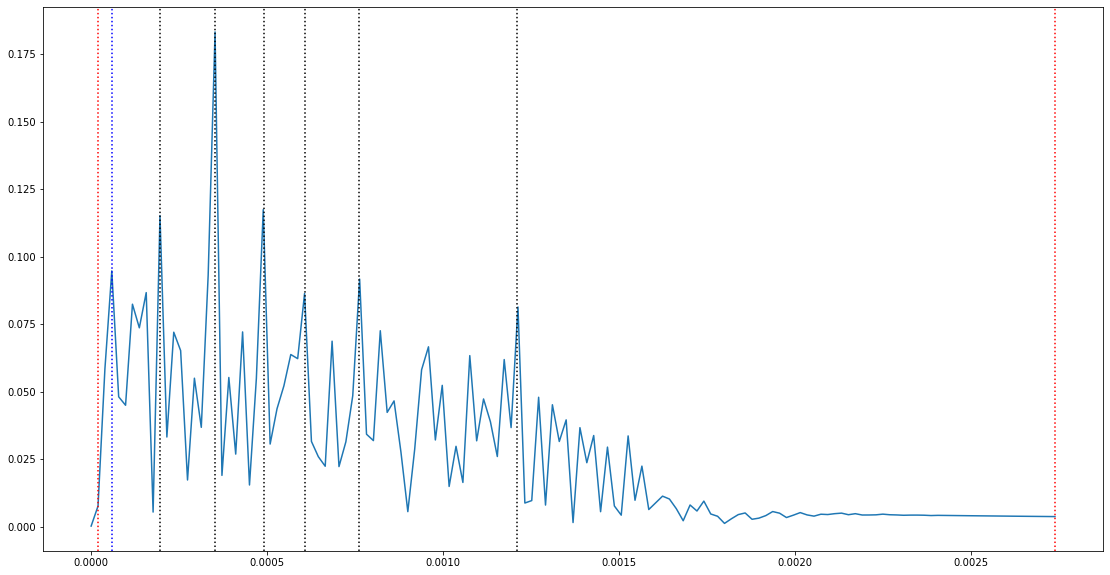

In [1251]:

# Sampling space
T = 1.0/365.25 

# fast fourier transform
fourier_signal = np.fft.fft(signal,n)/n
fourier_signal = fourier_signal[range(int(n/2))]

freq = np.arange(int(n/2))/n
plt.figure(figsize=(19,10))

sns.lineplot(x=freq[:141], y=np.abs(fourier_signal)[:141])
plt.axvline(1.955607705094358e-05, color='red', ls=':') # f = 1/1year
plt.axvline(0.0027378507871321013, color='red', ls=':') # f = 1/140year
plt.axvline(0.000197, color='black', ls=':') # peak 0
plt.axvline(0.000060, color='blue', ls=':') # peak 1
plt.axvline(0.000351, color='black', ls=':') # peak 2
#plt.axvline(0.000432, color='black', ls=':') # peak 3
plt.axvline(0.000491, color='black', ls=':') # peak 4
plt.axvline(0.000607, color='black', ls=':') # peak 5
#plt.axvline(0.000683, color='black', ls=':') # peak 6
plt.axvline(0.000762, color='black', ls=':') # peak 7
#plt.axvline(0.000824, color='black', ls=':') # peak 8
#plt.axvline(0.000959, color='black', ls=':') # peak 9
#plt.axvline(0.001075, color='black', ls=':') # peak 10
plt.axvline(0.001211, color='black', ls=':') # peak 11
plt.show
None

In [1252]:
frequencies = [0.000060,0.000197,0.000351,0.000491,0.000607,0.000762,0.001211] #Taking into account only the highest peaks

In [1253]:
# for a period of 1 year the frequency is 1/(365.25)
# We have taken the yearly mean so we can only consider 
# smaller than this frequencies
1.0/365.25

0.0027378507871321013

In [1254]:
# for a period of 140 year the frequency is 1/(140*365.25)
# We cannot consider larger than this frequencies
1.0/(140.0*365.25)
# for this reason we cannot consider the first peak

1.955607705094358e-05

In [1255]:
for i,frequency in enumerate(frequencies):
    T = 1.0/frequency
    T_year = T/365.25
    print(f'Period {i}: {T_year} years')

Period 0: 45.630846452201695 years
Period 1: 13.897719731635032 years
Period 2: 7.800144692684049 years
Period 3: 5.576070849556214 years
Period 4: 4.510462581766229 years
Period 5: 3.592980035606432 years
Period 6: 2.2608181561784484 years


In [1256]:
for i,frequency in enumerate(frequencies):
    df_train[f'freq_{i}_sinus'] = np.sin(2.0*np.pi*frequency*df_train['timestep'])
    df_train[f'freq_{i}_cos'] = np.cos(2.0*np.pi*frequency*df_train['timestep'])

In [1257]:
df_train

,T,timestep,timestep^2,timestep^3,interpolated,trend,freq_0_sinus,freq_0_cos,freq_1_sinus,freq_1_cos,freq_2_sinus,freq_2_cos,freq_3_sinus,freq_3_cos,freq_4_sinus,freq_4_cos,freq_5_sinus,freq_5_cos,freq_6_sinus,freq_6_cos
DATE,,,,,,,,,,,,,,,,,,,,
1876-01-01,2.2,0,0,0,11.121794,9.053141,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1876-01-02,2.5,1,1,1,11.106145,9.053130,0.000377,1.000000,0.001238,0.999999,0.002205,0.999998,0.003085,0.999995,0.003814,0.999993,0.004788,0.999989,0.007609,0.999971
1876-01-03,0.3,2,4,8,11.090567,9.053119,0.000754,1.000000,0.002476,0.999997,0.004411,0.999990,0.006170,0.999981,0.007628,0.999971,0.009575,0.999954,0.015217,0.999884
1876-01-04,-5.8,3,9,27,11.075060,9.053108,0.001131,0.999999,0.003713,0.999993,0.006616,0.999978,0.009255,0.999957,0.011441,0.999935,0.014363,0.999897,0.022825,0.999739
1876-01-05,-9.8,4,16,64,11.059625,9.053098,0.001508,0.999999,0.004951,0.999988,0.008821,0.999961,0.012340,0.999924,0.015255,0.999884,0.019150,0.999817,0.030431,0.999537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,10.7,51129,2614174641,133660135219689,9.095247,10.720026,0.412888,0.910782,0.439448,0.898268,-0.331166,0.943573,0.609620,0.792694,0.220001,0.975500,-0.246876,0.969047,-0.496992,0.867755
2015-12-28,7.2,51130,2614276900,133667977897000,9.077416,10.720143,0.413232,0.910626,0.440560,0.897723,-0.329084,0.944301,0.612063,0.790809,0.223720,0.974654,-0.242233,0.970218,-0.490375,0.871512
2015-12-29,4.5,51131,2614379161,133675820881091,9.059518,10.720261,0.413575,0.910470,0.441671,0.897177,-0.327001,0.945024,0.614499,0.788917,0.227435,0.973793,-0.237586,0.971367,-0.483729,0.875218


Another way to include seasonality is by creating bins.

In [1258]:
df_train['yearly_cycle'] = df_train.index.month # Yearly cycle
df_train.columns

Index(['T', 'timestep', 'timestep^2', 'timestep^3', 'interpolated', 'trend',
       'freq_0_sinus', 'freq_0_cos', 'freq_1_sinus', 'freq_1_cos',
       'freq_2_sinus', 'freq_2_cos', 'freq_3_sinus', 'freq_3_cos',
       'freq_4_sinus', 'freq_4_cos', 'freq_5_sinus', 'freq_5_cos',
       'freq_6_sinus', 'freq_6_cos', 'yearly_cycle'],
      dtype='object')

In [1259]:
df_train = pd.get_dummies(df_train, columns=['yearly_cycle'], drop_first=True, )

In [1260]:
df_train

,T,timestep,timestep^2,timestep^3,interpolated,trend,freq_0_sinus,freq_0_cos,freq_1_sinus,freq_1_cos,...,yearly_cycle_3,yearly_cycle_4,yearly_cycle_5,yearly_cycle_6,yearly_cycle_7,yearly_cycle_8,yearly_cycle_9,yearly_cycle_10,yearly_cycle_11,yearly_cycle_12
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-01,2.2,0,0,0,11.121794,9.053141,0.000000,1.000000,0.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0
1876-01-02,2.5,1,1,1,11.106145,9.053130,0.000377,1.000000,0.001238,0.999999,...,0,0,0,0,0,0,0,0,0,0
1876-01-03,0.3,2,4,8,11.090567,9.053119,0.000754,1.000000,0.002476,0.999997,...,0,0,0,0,0,0,0,0,0,0
1876-01-04,-5.8,3,9,27,11.075060,9.053108,0.001131,0.999999,0.003713,0.999993,...,0,0,0,0,0,0,0,0,0,0
1876-01-05,-9.8,4,16,64,11.059625,9.053098,0.001508,0.999999,0.004951,0.999988,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,10.7,51129,2614174641,133660135219689,9.095247,10.720026,0.412888,0.910782,0.439448,0.898268,...,0,0,0,0,0,0,0,0,0,1
2015-12-28,7.2,51130,2614276900,133667977897000,9.077416,10.720143,0.413232,0.910626,0.440560,0.897723,...,0,0,0,0,0,0,0,0,0,1
2015-12-29,4.5,51131,2614379161,133675820881091,9.059518,10.720261,0.413575,0.910470,0.441671,0.897177,...,0,0,0,0,0,0,0,0,0,1


In [1261]:
m_seasonal_trend = LinearRegression()
m_seasonal_trend.fit(df_train.drop(columns=['T','interpolated', 'trend']), df_train['T'])

LinearRegression()

In [1262]:
m_seasonal_trend.score(df_train.drop(columns=['T','interpolated', 'trend']), df_train['T'])

0.7552006036003657

In [1263]:
df_train['seasonal_trend'] = m_seasonal_trend.predict(df_train.drop(columns=['T','interpolated', 'trend']))

<AxesSubplot:xlabel='DATE', ylabel='T'>

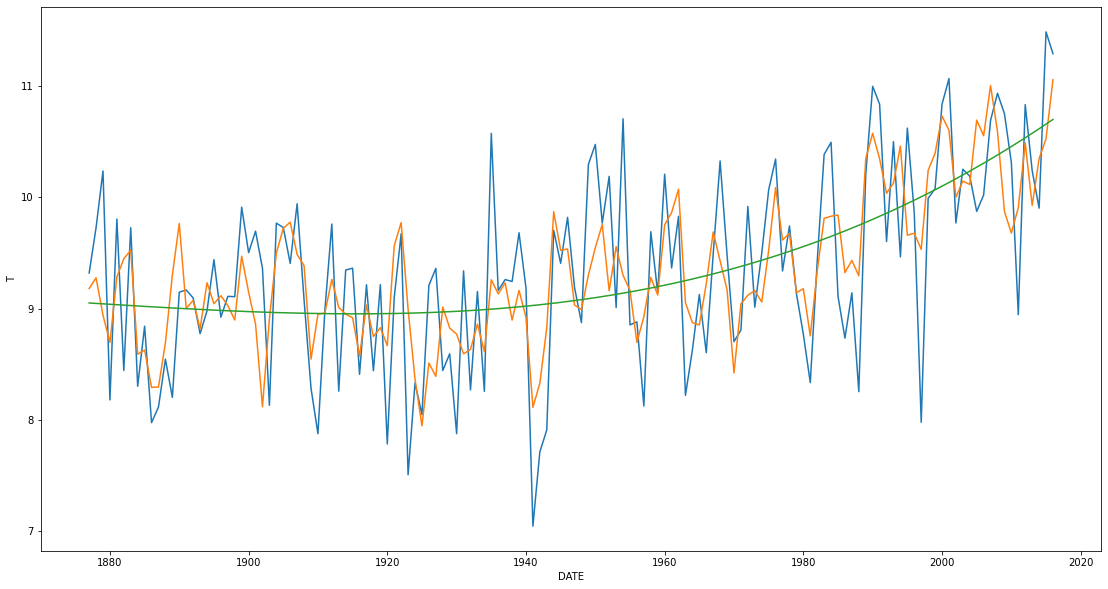

In [1264]:
plt.figure(figsize=(19,10)) #Fix this
sns.lineplot(data=df_train.resample('Y').mean(), y ='T', x ='DATE')
sns.lineplot(data=df_train.resample('Y').mean(), y ='seasonal_trend', x ='DATE')
sns.lineplot(data=df_train.resample('Y').mean(), y ='trend', x ='DATE')

In [1265]:
df_train['remainder'] = df_train['T'] - df_train['seasonal_trend']

In [1266]:
df_train['T'].describe()

count    51134.000000
mean         9.341266
std          7.875370
min        -22.600000
25%          3.300000
50%          9.400000
75%         15.700000
max         30.500000
Name: T, dtype: float64

In [1267]:
df_train['remainder'].describe()

count    5.113400e+04
mean    -8.652505e-16
std      3.896513e+00
min     -2.276563e+01
25%     -2.594893e+00
50%      3.283108e-03
75%      2.648740e+00
max      1.495326e+01
Name: remainder, dtype: float64

<AxesSubplot:xlabel='T', ylabel='Count'>

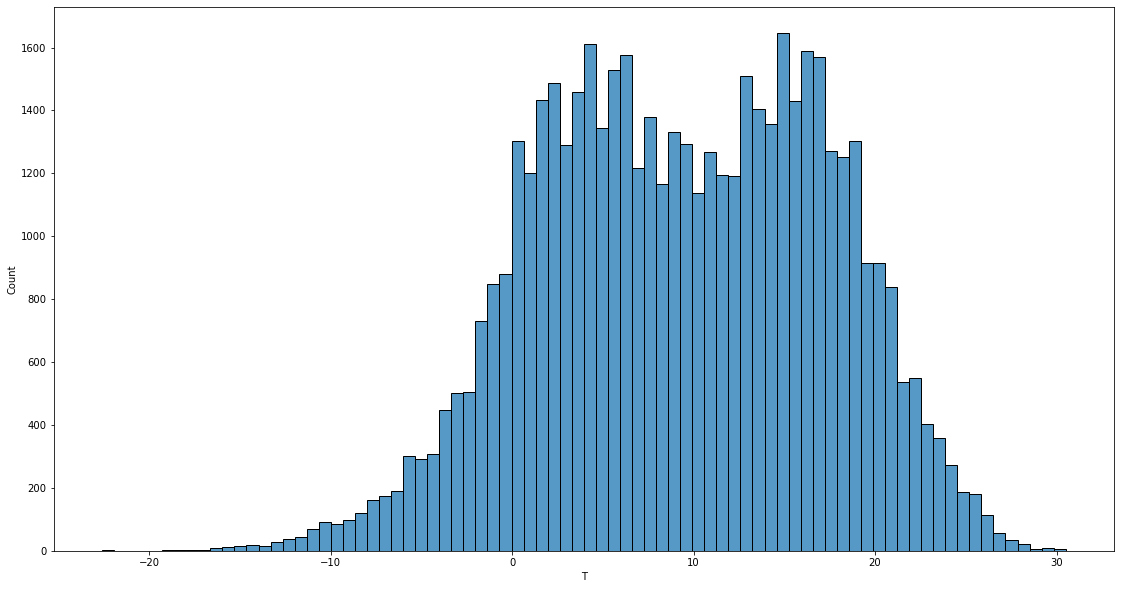

In [1268]:
plt.figure(figsize=(19,10))
sns.histplot(data=df_train, x ='T')

<AxesSubplot:xlabel='remainder', ylabel='Count'>

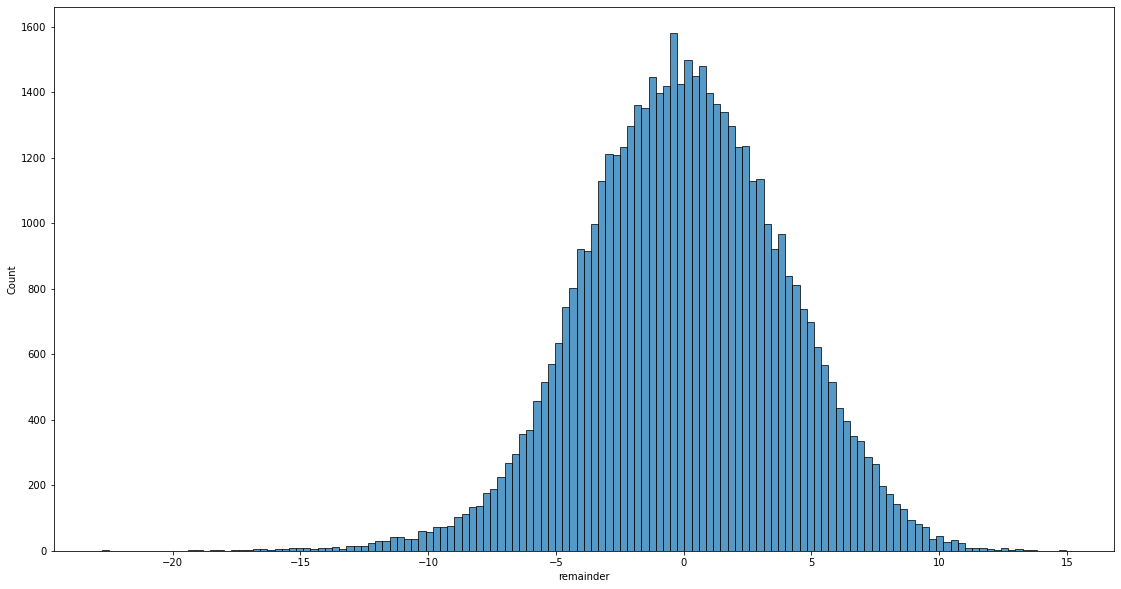

In [1269]:
plt.figure(figsize=(19,10))
sns.histplot(data=df_train, x ='remainder')

<AxesSubplot:xlabel='DATE', ylabel='T'>

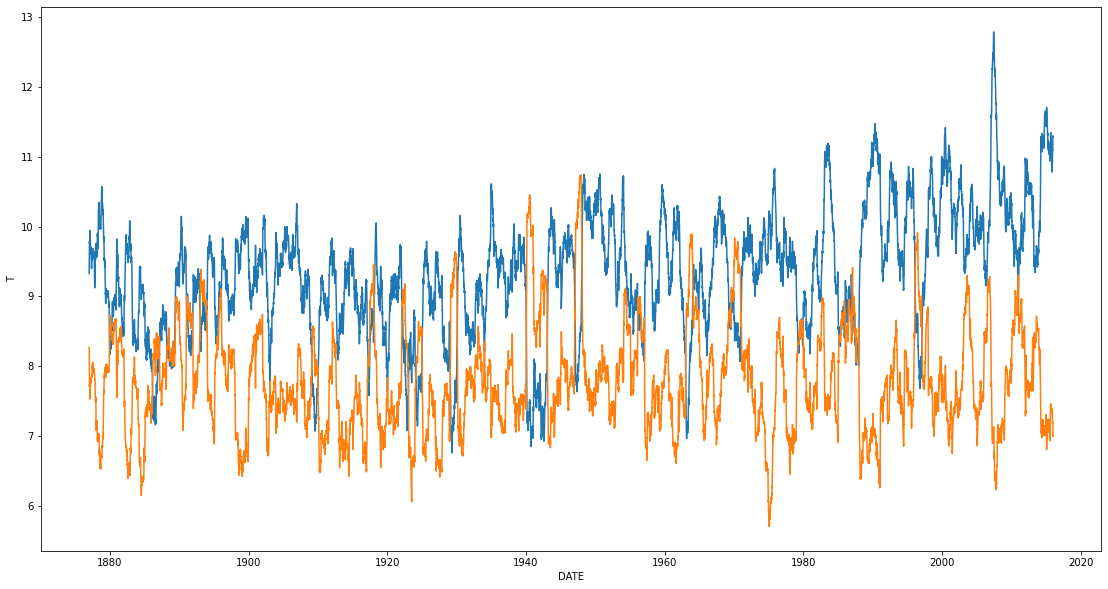

In [1270]:
plt.figure(figsize=(19,10))
sns.lineplot(data =df_train.rolling(365).mean(), y ='T', x ='DATE')
sns.lineplot(data =df_train.rolling(365).std(), y ='T', x ='DATE')

<AxesSubplot:xlabel='DATE', ylabel='remainder'>

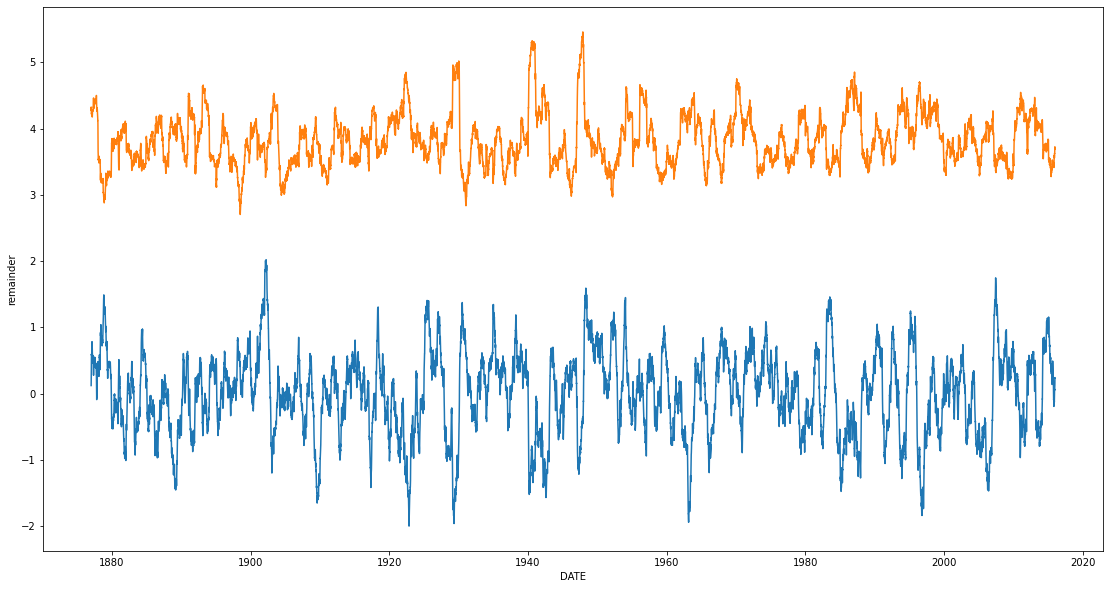

In [1271]:
plt.figure(figsize=(19,10))
sns.lineplot(data =df_train.rolling(365).mean(), y ='remainder', x ='DATE')
sns.lineplot(data =df_train.rolling(365).std(), y ='remainder', x ='DATE')

# Model validation with test data

In [1272]:
df

,T
DATE,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8
...,...
2022-01-27,4.4
2022-01-28,4.9
2022-01-29,5.8


In [1273]:
# Here we create the columns according to the above exploration for the full dataset. 
# We need our test and train sets to have the same number of columns.
df['timestep'] = list(range(len(df)))
df['timestep^2'] = df['timestep']**2
df['timestep^3'] = df['timestep']**3
df['yearly_cycle'] = df.index.month # Yearly cycle
for i,frequency in enumerate(frequencies):
    df[f'freq_{i}_sinus'] = np.sin(2.0*np.pi*frequency*df['timestep'])
    df[f'freq_{i}_cos'] = np.cos(2.0*np.pi*frequency*df['timestep'])
df = pd.get_dummies(df, columns=['yearly_cycle'], drop_first=True, )
df

,T,timestep,timestep^2,timestep^3,freq_0_sinus,freq_0_cos,freq_1_sinus,freq_1_cos,freq_2_sinus,freq_2_cos,...,yearly_cycle_3,yearly_cycle_4,yearly_cycle_5,yearly_cycle_6,yearly_cycle_7,yearly_cycle_8,yearly_cycle_9,yearly_cycle_10,yearly_cycle_11,yearly_cycle_12
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-01,2.2,0,0,0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0
1876-01-02,2.5,1,1,1,0.000377,1.000000,0.001238,0.999999,0.002205,0.999998,...,0,0,0,0,0,0,0,0,0,0
1876-01-03,0.3,2,4,8,0.000754,1.000000,0.002476,0.999997,0.004411,0.999990,...,0,0,0,0,0,0,0,0,0,0
1876-01-04,-5.8,3,9,27,0.001131,0.999999,0.003713,0.999993,0.006616,0.999978,...,0,0,0,0,0,0,0,0,0,0
1876-01-05,-9.8,4,16,64,0.001508,0.999999,0.004951,0.999988,0.008821,0.999961,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-27,4.4,53352,2846435904,151863048350208,0.953208,0.302317,-0.064948,-0.997889,-0.989167,-0.146796,...,0,0,0,0,0,0,0,0,0,0
2022-01-28,4.9,53353,2846542609,151871587817977,0.953321,0.301957,-0.066183,-0.997808,-0.989488,-0.144614,...,0,0,0,0,0,0,0,0,0,0
2022-01-29,5.8,53354,2846649316,151880127605864,0.953435,0.301598,-0.067418,-0.997725,-0.989805,-0.142431,...,0,0,0,0,0,0,0,0,0,0


In [1274]:
# Train-test split
X_train_all = df.drop(columns=['T']).loc[:'2015-12-31']
y_train = df['T'].loc[:'2015-12-31']
X_test_all = df.drop(columns=['T']).loc['2016-01-01':]
y_test = df['T'].loc['2016-01-01':]

In [1275]:
X_train_all.columns

Index(['timestep', 'timestep^2', 'timestep^3', 'freq_0_sinus', 'freq_0_cos',
       'freq_1_sinus', 'freq_1_cos', 'freq_2_sinus', 'freq_2_cos',
       'freq_3_sinus', 'freq_3_cos', 'freq_4_sinus', 'freq_4_cos',
       'freq_5_sinus', 'freq_5_cos', 'freq_6_sinus', 'freq_6_cos',
       'yearly_cycle_2', 'yearly_cycle_3', 'yearly_cycle_4', 'yearly_cycle_5',
       'yearly_cycle_6', 'yearly_cycle_7', 'yearly_cycle_8', 'yearly_cycle_9',
       'yearly_cycle_10', 'yearly_cycle_11', 'yearly_cycle_12'],
      dtype='object')

In [1276]:
X_test_all.columns

Index(['timestep', 'timestep^2', 'timestep^3', 'freq_0_sinus', 'freq_0_cos',
       'freq_1_sinus', 'freq_1_cos', 'freq_2_sinus', 'freq_2_cos',
       'freq_3_sinus', 'freq_3_cos', 'freq_4_sinus', 'freq_4_cos',
       'freq_5_sinus', 'freq_5_cos', 'freq_6_sinus', 'freq_6_cos',
       'yearly_cycle_2', 'yearly_cycle_3', 'yearly_cycle_4', 'yearly_cycle_5',
       'yearly_cycle_6', 'yearly_cycle_7', 'yearly_cycle_8', 'yearly_cycle_9',
       'yearly_cycle_10', 'yearly_cycle_11', 'yearly_cycle_12'],
      dtype='object')

In [1277]:
df_test.columns

Index(['T'], dtype='object')

In [1278]:
m_all = LinearRegression()

In [1279]:
m_all.fit(X_train_all, y_train)
print(m_all.score(X_train_all, y_train))
print(m_all.score(X_test_all, y_test))
df['seasonal_trend'] = 0
df['seasonal_trend'].loc[:'2015-12-31'] = m_all.predict(X_train_all)
df['seasonal_trend'].loc['2016-01-01':] = m_all.predict(X_test_all)

0.7552006036003657
0.7625013410810982


/var/folders/c4/jkw5wy1d7lndc6p4y832vmrc0000gn/T/ipykernel_71172/3029632446.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['seasonal_trend'].loc[:'2015-12-31'] = m_all.predict(X_train_all)


In [1280]:
df

,T,timestep,timestep^2,timestep^3,freq_0_sinus,freq_0_cos,freq_1_sinus,freq_1_cos,freq_2_sinus,freq_2_cos,...,yearly_cycle_4,yearly_cycle_5,yearly_cycle_6,yearly_cycle_7,yearly_cycle_8,yearly_cycle_9,yearly_cycle_10,yearly_cycle_11,yearly_cycle_12,seasonal_trend
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-01,2.2,0,0,0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0.069076
1876-01-02,2.5,1,1,1,0.000377,1.000000,0.001238,0.999999,0.002205,0.999998,...,0,0,0,0,0,0,0,0,0,0.067577
1876-01-03,0.3,2,4,8,0.000754,1.000000,0.002476,0.999997,0.004411,0.999990,...,0,0,0,0,0,0,0,0,0,0.066068
1876-01-04,-5.8,3,9,27,0.001131,0.999999,0.003713,0.999993,0.006616,0.999978,...,0,0,0,0,0,0,0,0,0,0.064550
1876-01-05,-9.8,4,16,64,0.001508,0.999999,0.004951,0.999988,0.008821,0.999961,...,0,0,0,0,0,0,0,0,0,0.063022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-27,4.4,53352,2846435904,151863048350208,0.953208,0.302317,-0.064948,-0.997889,-0.989167,-0.146796,...,0,0,0,0,0,0,0,0,0,1.717483
2022-01-28,4.9,53353,2846542609,151871587817977,0.953321,0.301957,-0.066183,-0.997808,-0.989488,-0.144614,...,0,0,0,0,0,0,0,0,0,1.718581
2022-01-29,5.8,53354,2846649316,151880127605864,0.953435,0.301598,-0.067418,-0.997725,-0.989805,-0.142431,...,0,0,0,0,0,0,0,0,0,1.719673


In [1281]:
df['remainder'] = df['T'] - df['seasonal_trend'] 

In [1282]:
df['remainder'].describe()

count    53357.000000
mean         0.030019
std          3.890873
min        -22.765635
25%         -2.555717
50%          0.029976
75%          2.671337
max         14.953264
Name: remainder, dtype: float64

In [1283]:
from statsmodels.tsa.seasonal import seasonal_decompose

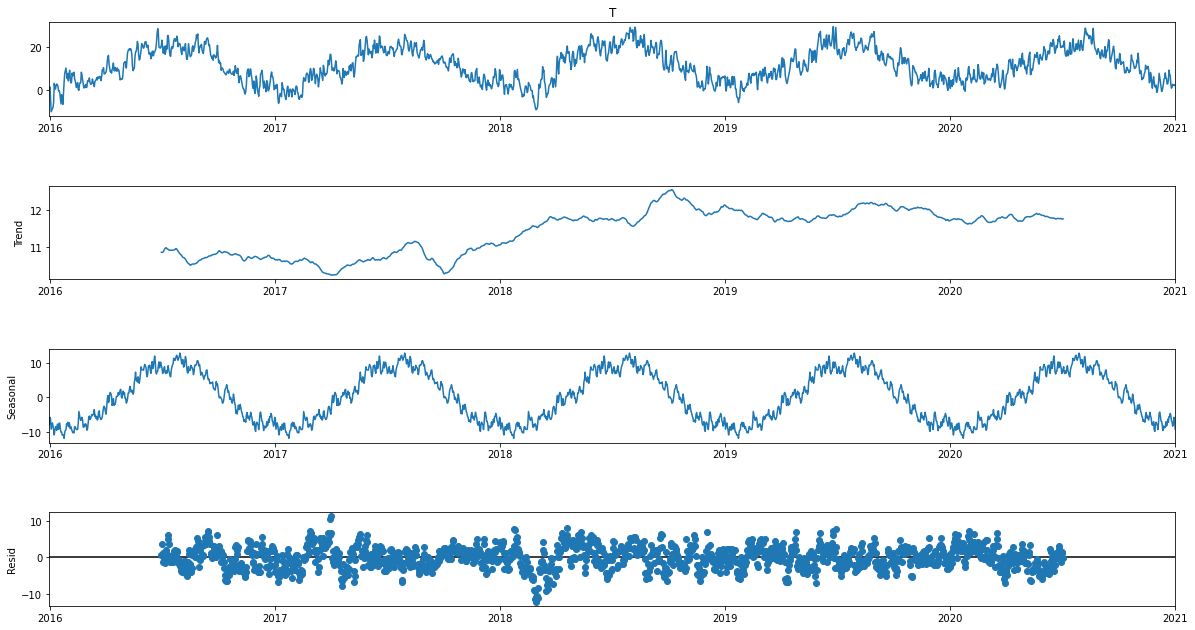

In [1325]:
decomposed_T = seasonal_decompose(df['T'].loc['2015-12-31':'2021-01-01'],period=365)
fig = decomposed_T.plot()
fig.set_size_inches(19,10)

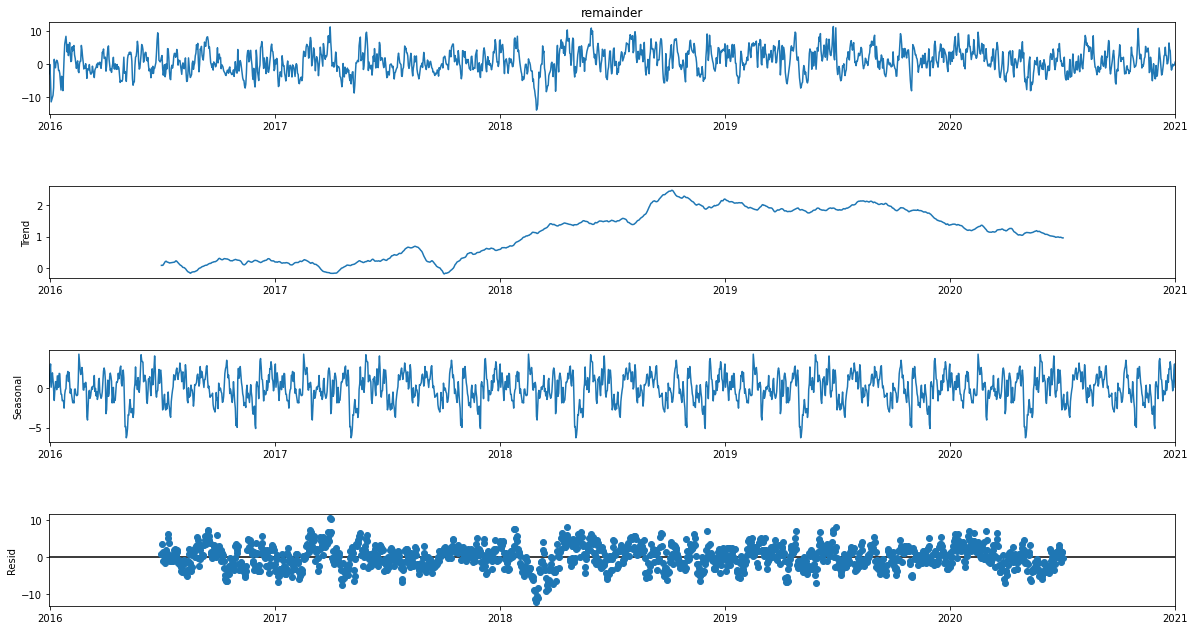

In [1326]:
decomposed = seasonal_decompose(df['remainder'].loc['2015-12-31':'2021-01-01'],period=365)
fig = decomposed.plot()
fig.set_size_inches(19,10)

In [1327]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

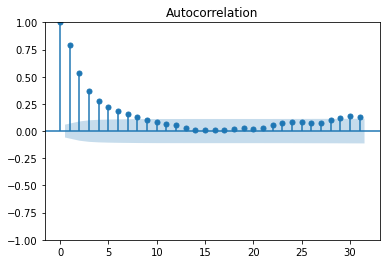

In [1328]:
plot_acf(df['remainder'].loc['2018-12-31':'2022-01-01']);

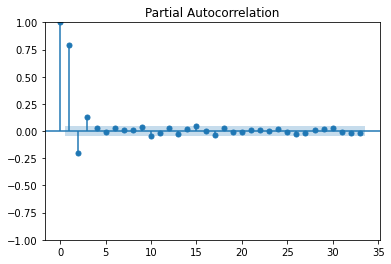

In [1329]:
plot_pacf(df['remainder'].loc['2015-12-31':'2021-01-01'].asfreq('d'),method='ywm');

In [1289]:
from statsmodels.tsa.arima.model import ARIMA

In [1330]:
df

,T,timestep,timestep^2,timestep^3,freq_0_sinus,freq_0_cos,freq_1_sinus,freq_1_cos,freq_2_sinus,freq_2_cos,...,yearly_cycle_5,yearly_cycle_6,yearly_cycle_7,yearly_cycle_8,yearly_cycle_9,yearly_cycle_10,yearly_cycle_11,yearly_cycle_12,seasonal_trend,remainder
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-01,2.2,0,0,0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0,0,0,0,0,0,0,0,0.069076,2.130924
1876-01-02,2.5,1,1,1,0.000377,1.000000,0.001238,0.999999,0.002205,0.999998,...,0,0,0,0,0,0,0,0,0.067577,2.432423
1876-01-03,0.3,2,4,8,0.000754,1.000000,0.002476,0.999997,0.004411,0.999990,...,0,0,0,0,0,0,0,0,0.066068,0.233932
1876-01-04,-5.8,3,9,27,0.001131,0.999999,0.003713,0.999993,0.006616,0.999978,...,0,0,0,0,0,0,0,0,0.064550,-5.864550
1876-01-05,-9.8,4,16,64,0.001508,0.999999,0.004951,0.999988,0.008821,0.999961,...,0,0,0,0,0,0,0,0,0.063022,-9.863022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-27,4.4,53352,2846435904,151863048350208,0.953208,0.302317,-0.064948,-0.997889,-0.989167,-0.146796,...,0,0,0,0,0,0,0,0,1.717483,2.682517
2022-01-28,4.9,53353,2846542609,151871587817977,0.953321,0.301957,-0.066183,-0.997808,-0.989488,-0.144614,...,0,0,0,0,0,0,0,0,1.718581,3.181419
2022-01-29,5.8,53354,2846649316,151880127605864,0.953435,0.301598,-0.067418,-0.997725,-0.989805,-0.142431,...,0,0,0,0,0,0,0,0,1.719673,4.080327


In [1331]:
help(ARIMA.fit)

Help on function fit in module statsmodels.tsa.arima.model:

fit(self, start_params=None, transformed=True, includes_fixed=False, method=None, method_kwargs=None, gls=None, gls_kwargs=None, cov_type=None, cov_kwds=None, return_params=False, low_memory=False)
    Fit (estimate) the parameters of the model.
    
    Parameters
    ----------
    start_params : array_like, optional
        Initial guess of the solution for the loglikelihood maximization.
        If None, the default is given by Model.start_params.
    transformed : bool, optional
        Whether or not `start_params` is already transformed. Default is
        True.
    includes_fixed : bool, optional
        If parameters were previously fixed with the `fix_params` method,
        this argument describes whether or not `start_params` also includes
        the fixed parameters, in addition to the free parameters. Default
        is False.
    method : str, optional
        The method used for estimating the parameters of t

In [1343]:
time_series = df.loc['2015-12-31':'2021-01-01']['remainder']

In [1344]:
time_series = pd.DataFrame(time_series).asfreq('d')

In [1345]:
time_series

,remainder
DATE,
2015-12-31,-2.889073
2016-01-01,-0.158088
2016-01-02,-5.356902
2016-01-03,-11.555700
2016-01-04,-10.854482
...,...
2020-12-28,-0.042432
2020-12-29,-0.542171
2020-12-30,-0.341907


### creating the model

In [1346]:
arima_model = ARIMA(time_series, order=(4, 0, 7),freq='D')

In [1347]:
arima_model_fit = arima_model.fit(method='innovations_mle')

In [1297]:
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              remainder   No. Observations:                 1098
Model:                 ARIMA(4, 0, 7)   Log Likelihood               -2409.413
Date:                Sat, 28 May 2022   AIC                           4844.825
Time:                        12:44:56   BIC                           4909.841
Sample:                    12-31-2018   HQIC                          4869.423
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8273      0.311      2.662      0.008       0.218       1.436
ar.L1         -1.0957      0.957     -1.145      0.252      -2.971       0.780
ar.L2          0.6063      1.102      0.550      0.5

<AxesSubplot:ylabel='Density'>

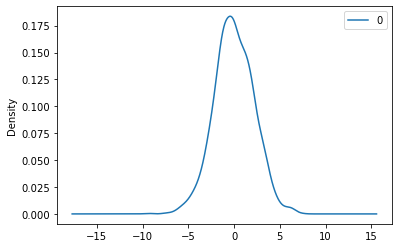

In [1348]:
residuals = pd.DataFrame(arima_model_fit.resid)
residuals.plot(kind='kde')

In [1349]:
residuals.describe()

,0
count,1829.000000
mean,0.002079
std,2.165953
min,-9.379328
25%,-1.391437
50%,-0.051026
75%,1.476310
max,7.250894


# Evaluation

### testing forcast

In [1350]:
output = arima_model_fit.forecast(steps=3)

In [1351]:
output

2021-01-02    0.756822
2021-01-03    0.834656
2021-01-04    0.734239
Freq: D, Name: predicted_mean, dtype: float64

In [1352]:
df['remainder'].loc['2021-01-02':].head(3)

DATE
2021-01-02   -0.411284
2021-01-03   -0.911011
2021-01-04   -0.710735
Name: remainder, dtype: float64

# Daily forcast

In [1353]:
from sklearn.metrics import mean_squared_error,mean_absolute_error


In [1358]:
test_time_series = df['remainder'].loc['2021-01-02':'2022-01-01'].asfreq('d')

In [1359]:
history = time_series
daily_predictions = []
for i,residual_T in enumerate(test_time_series):
	print(residual_T)
	model = ARIMA(history, order=(4,0,7), freq='D')
	model_fit = model.fit(method='innovations_mle')
	output = model_fit.forecast()
	print('output:')
	print(pd.DataFrame({'remainder':output[0]}, index=output.index))
	history = pd.concat([history,pd.DataFrame({'remainder':residual_T}, index=output.index).asfreq('d')])
	yhat = output[0]
	daily_predictions.append(yhat)
	print('predicted=%f, expected=%f' % (yhat, residual_T))


-0.41128421080149025
output:
            remainder
2021-01-02   0.756822
predicted=0.756822, expected=-0.411284
-0.9110105751879849
output:
            remainder
2021-01-03  -0.302622
predicted=-0.302622, expected=-0.911011
-0.7107347951957348
output:
            remainder
2021-01-04  -0.627513
predicted=-0.627513, expected=-0.710735
0.18954304015318657
output:
            remainder
2021-01-05  -0.344217
predicted=-0.344217, expected=0.189543
0.48982284190658887
output:
            remainder
2021-01-06   0.619045
predicted=0.619045, expected=0.489823
-0.20989547881180814
output:
            remainder
2021-01-07   0.467475
predicted=0.467475, expected=-0.209895
-0.40961201079632636
output:
            remainder
2021-01-08  -0.218598
predicted=-0.218598, expected=-0.409612
0.09067315724658132
output:
            remainder
2021-01-09  -0.046664
predicted=-0.046664, expected=0.090673
-0.7090400632955862
output:
            remainder
2021-01-10   0.332714
predicted=0.332714, expected=-0.709

/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima/estimators/gls.py:296: UserWarning: Feasible GLS failed to converge in 50 iterations. Consider increasing the maximum number of iterations using the `max_iter` argument or reducing the required tolerance using the `tolerance` argument.
  warnings.warn('Feasible GLS failed to converge in %d iterations.'


output:
            remainder
2021-02-01  -5.379141
predicted=-5.379141, expected=-5.736557
-1.436257396040903
output:
            remainder
2021-02-02  -4.154984
predicted=-4.154984, expected=-1.436257
2.5640418221754624
output:
            remainder
2021-02-03    0.20931
predicted=0.209310, expected=2.564042
-1.4356595156336365
output:
            remainder
2021-02-04   2.422865
predicted=2.422865, expected=-1.435660
-2.5353614935665183
output:
            remainder
2021-02-05  -2.334015
predicted=-2.334015, expected=-2.535361
-4.435064195469752
output:
            remainder
2021-02-06  -1.667596
predicted=-1.667596, expected=-4.435064
-8.53476770493252
output:
            remainder
2021-02-07  -3.694301
predicted=-3.694301, expected=-8.534768
-11.434472105280989
output:
            remainder
2021-02-08   -7.07409
predicted=-7.074090, expected=-11.434472
-10.734177479572732
output:
            remainder
2021-02-09  -8.443035
predicted=-8.443035, expected=-10.734177
-9.633883910591063

/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima/estimators/gls.py:296: UserWarning: Feasible GLS failed to converge in 50 iterations. Consider increasing the maximum number of iterations using the `max_iter` argument or reducing the required tolerance using the `tolerance` argument.
  warnings.warn('Feasible GLS failed to converge in %d iterations.'


output:
            remainder
2021-04-03   -3.40783
predicted=-3.407830, expected=-4.862874
-4.762746202383403
output:
            remainder
2021-04-04  -2.900192
predicted=-2.900192, expected=-4.762746
-6.762622918270283
output:
            remainder
2021-04-05  -3.508268
predicted=-3.508268, expected=-6.762623
-8.362504667438362
output:
            remainder
2021-04-06   -5.51636
predicted=-5.516360, expected=-8.362505
-7.262391509100853
output:
            remainder
2021-04-07  -6.328891
predicted=-6.328891, expected=-7.262392
-5.862283501918553
output:
            remainder
2021-04-08  -5.078567
predicted=-5.078567, expected=-5.862284
-2.1621807039958707
output:
            remainder
2021-04-09  -4.365346
predicted=-4.365346, expected=-2.162181
-2.862083172876826
output:
            remainder
2021-04-10  -0.915475
predicted=-0.915475, expected=-2.862083
0.938009034458851
output:
            remainder
2021-04-11  -2.737334
predicted=-2.737334, expected=0.938009
-5.261904138400353
ou

In [1363]:
results = pd.DataFrame(test_time_series)
results['total'] = results['remainder'] + df['seasonal_trend'].loc['2021-01-02':'2022-01-01']
results['predictions'] = daily_predictions + df['seasonal_trend'].loc['2021-01-02':'2022-01-01']

In [1364]:
results

,remainder,total,predictions
DATE,,,
2021-01-02,-0.411284,1.1,2.268106
2021-01-03,-0.911011,0.6,1.208389
2021-01-04,-0.710735,0.8,0.883222
2021-01-05,0.189543,1.7,1.166240
2021-01-06,0.489823,2.0,2.129222
...,...,...,...
2021-12-28,-3.512284,-0.5,-1.029028
2021-12-29,1.486498,4.5,0.614833
2021-12-30,6.285282,9.3,4.841928


MAE: 1.68
RMSE: 2.19


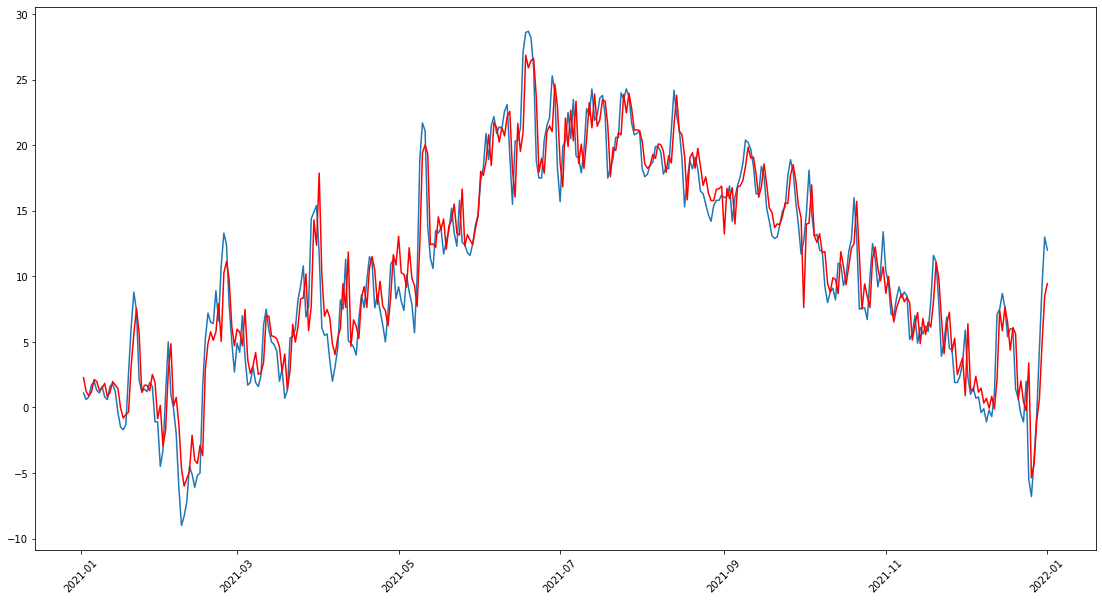

In [1366]:
mae = mean_absolute_error(results['total'], results['predictions'])
print('MAE: %.2f' % mae)
rmse = np.sqrt(mean_squared_error(results['total'], results['predictions']))
print('RMSE: %.2f' % rmse)
# plot forecasts against actual outcomes
plt.figure(figsize=(19,10))
plt.plot(results['total'])
plt.plot(results['predictions'], color='red')
plt.xticks(rotation=45)
plt.show()

# 3-day predicitions 

In [1367]:
time_series

,remainder
DATE,
2015-12-31,-2.889073
2016-01-01,-0.158088
2016-01-02,-5.356902
2016-01-03,-11.555700
2016-01-04,-10.854482
...,...
2020-12-28,-0.042432
2020-12-29,-0.542171
2020-12-30,-0.341907


In [1368]:
test_time_series

DATE
2021-01-02    -0.411284
2021-01-03    -0.911011
2021-01-04    -0.710735
2021-01-05     0.189543
2021-01-06     0.489823
                ...    
2021-12-28    -3.512284
2021-12-29     1.486498
2021-12-30     6.285282
2021-12-31     9.984069
2022-01-01    10.312675
Freq: D, Name: remainder, Length: 365, dtype: float64

In [1370]:
history = time_series
diffs = []
for j in range(350):
    predictions = []
    residual_T =test_time_series.iloc[j:j+3]
    print(residual_T)
    model = ARIMA(history, order=(4,0,7),freq='D')
    model_fit = model.fit(method='innovations_mle')
    output = model_fit.forecast(steps=3)
    print('output:')
    print(pd.DataFrame(output))
    history = pd.concat([history,pd.DataFrame(test_time_series.iloc[j:j+1]).asfreq('D')])
    yhat = list(output)
    predictions.append(yhat)
    for i in range(3):
        print('predicted=%f, expected=%f' % (yhat[i], residual_T[i]))
        diffs.append(np.abs(yhat[i] - residual_T[i]))

DATE
2021-01-02   -0.411284
2021-01-03   -0.911011
2021-01-04   -0.710735
Freq: D, Name: remainder, dtype: float64
output:
            predicted_mean
2021-01-02        0.756822
2021-01-03        0.834656
2021-01-04        0.734239
predicted=0.756822, expected=-0.411284
predicted=0.834656, expected=-0.911011
predicted=0.734239, expected=-0.710735
DATE
2021-01-03   -0.911011
2021-01-04   -0.710735
2021-01-05    0.189543
Freq: D, Name: remainder, dtype: float64
output:
            predicted_mean
2021-01-03       -0.302622
2021-01-04       -0.005072
2021-01-05        0.210258
predicted=-0.302622, expected=-0.911011
predicted=-0.005072, expected=-0.710735
predicted=0.210258, expected=0.189543
DATE
2021-01-04   -0.710735
2021-01-05    0.189543
2021-01-06    0.489823
Freq: D, Name: remainder, dtype: float64
output:
            predicted_mean
2021-01-04       -0.627513
2021-01-05       -0.263160
2021-01-06        0.176174
predicted=-0.627513, expected=-0.710735
predicted=-0.263160, expected=0.

/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima/estimators/gls.py:296: UserWarning: Feasible GLS failed to converge in 50 iterations. Consider increasing the maximum number of iterations using the `max_iter` argument or reducing the required tolerance using the `tolerance` argument.
  warnings.warn('Feasible GLS failed to converge in %d iterations.'


output:
            predicted_mean
2021-02-01       -5.379141
2021-02-02       -3.245205
2021-02-03       -2.074500
predicted=-5.379141, expected=-5.736557
predicted=-3.245205, expected=-1.436257
predicted=-2.074500, expected=2.564042
DATE
2021-02-02   -1.436257
2021-02-03    2.564042
2021-02-04   -1.435660
Freq: D, Name: remainder, dtype: float64
output:
            predicted_mean
2021-02-02       -4.154984
2021-02-03       -2.682252
2021-02-04       -1.856303
predicted=-4.154984, expected=-1.436257
predicted=-2.682252, expected=2.564042
predicted=-1.856303, expected=-1.435660
DATE
2021-02-03    2.564042
2021-02-04   -1.435660
2021-02-05   -2.535361
Freq: D, Name: remainder, dtype: float64
output:
            predicted_mean
2021-02-03        0.209310
2021-02-04       -0.056594
2021-02-05       -0.227731
predicted=0.209310, expected=2.564042
predicted=-0.056594, expected=-1.435660
predicted=-0.227731, expected=-2.535361
DATE
2021-02-04   -1.435660
2021-02-05   -2.535361
2021-02-06   -4

/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima/estimators/gls.py:296: UserWarning: Feasible GLS failed to converge in 50 iterations. Consider increasing the maximum number of iterations using the `max_iter` argument or reducing the required tolerance using the `tolerance` argument.
  warnings.warn('Feasible GLS failed to converge in %d iterations.'


output:
            predicted_mean
2021-04-03       -3.407830
2021-04-04       -1.386974
2021-04-05       -0.612577
predicted=-3.407830, expected=-4.862874
predicted=-1.386974, expected=-4.762746
predicted=-0.612577, expected=-6.762623
DATE
2021-04-04   -4.762746
2021-04-05   -6.762623
2021-04-06   -8.362505
Freq: D, Name: remainder, dtype: float64
output:
            predicted_mean
2021-04-04       -2.900192
2021-04-05       -1.426717
2021-04-06       -0.870140
predicted=-2.900192, expected=-4.762746
predicted=-1.426717, expected=-6.762623
predicted=-0.870140, expected=-8.362505
DATE
2021-04-05   -6.762623
2021-04-06   -8.362505
2021-04-07   -7.262392
Freq: D, Name: remainder, dtype: float64
output:
            predicted_mean
2021-04-05       -3.508268
2021-04-06       -2.236889
2021-04-07       -1.487646
predicted=-3.508268, expected=-6.762623
predicted=-2.236889, expected=-8.362505
predicted=-1.487646, expected=-7.262392
DATE
2021-04-06   -8.362505
2021-04-07   -7.262392
2021-04-08 

In [1371]:
mae = np.array(diffs).mean()
print(f'Mean absolute error for a 3-day daily mean temperature: {mae:.2f}')

Mean absolute error for a 3-day daily mean temperature: 2.30


In [ ]:
# TODO: Create DF with all predictions and true values